In [6]:
%matplotlib widget
import scipy
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import shapely

In [3]:
ais_final = gpd.read_file('basins/shapefiles/ANT_basins_thresh1000.shp')
gris_final = gpd.read_file('basins/shapefiles/GRE_basins_thresh2000.shp')
coast = gpd.read_file('basins/shapefiles/Coastline_Antarctica_v02.shp')
shelf = gpd.read_file('basins/shapefiles/IceShelf_Antarctica_v02.shp')
ground = gpd.read_file('basins/shapefiles/GroundingLine_Antarctica_v02.shp')
ant_merged = gpd.read_file('basins/shapefiles/ANT_basins_merged.shp')
gre_merged = gpd.read_file('basins/shapefiles/GRE_basins_merged.shp')
amery = shelf[shelf.NAME == 'Amery']
bc = ais_final.loc[ais_final.Subregions=='B-C']
cw = gris_final.loc[gris_final.SUBREGION1=='CW']
bc_full = ant_merged.loc[ant_merged.Subregions=='B-C']
cw_full = gre_merged.loc[gre_merged.SUBREGION1=='CW']

with open('data/fdm/fdm_gre_cw_ru.pkl', 'rb') as file:
    ru_gre = pickle.load(file)
area19 = ru_gre['ru19'].copy()
area19[~np.isnan(area19)] = 1
area20 = ru_gre['ru20'].copy()
area20[~np.isnan(area20)] = 1

In [4]:
shelf.to_crs('epsg:4326').geometry.bounds

,minx,miny,maxx,maxy
0,-26.858063,-76.146068,-26.629119,-76.091118
1,-114.294871,-74.096324,-113.841080,-73.959504
2,-101.745755,-73.712942,-101.621118,-73.673012
3,-135.972694,-74.750694,-135.626451,-74.668983
4,-61.899864,-69.588955,-61.666442,-69.530850
...,...,...,...,...
176,-61.039749,-74.425694,-60.893278,-74.382323
177,-27.886591,-76.259693,-27.694229,-76.219818
178,47.008793,-67.718868,48.006233,-67.412557
179,-79.623759,-73.111904,-79.491057,-73.084033


In [78]:
rgt_ant = gpd.read_file('data/kmls/rgt_ant.shp').to_crs(ais_final.crs)[['Name', 'geometry']]
rgt_ant['geometry'] = shapely.wkb.loads(shapely.wkb.dumps(rgt_ant.geometry, output_dimension=2))
rgt_bc = gpd.clip(rgt_ant, bc).copy()

rgt_gre = gpd.read_file('data/kmls/rgt_gre.shp').to_crs(gris_final.crs)[['Name', 'geometry']]
rgt_gre['geometry'] = shapely.wkb.loads(shapely.wkb.dumps(rgt_ant.geometry, output_dimension=2))
rgt_cw = gpd.clip(rgt_gre, cw).copy()

region_locs = {
    'NO': {'x': -120431.650, 'y': -1168898.581},
    'NW': {'x': -78158.149, 'y': -1645985.187},
    'NE': {'x': 228324.732, 'y': -1440656.812},
    'CW': {'x': 90935.854, 'y': -2097405.797},
    'CE': {'x': 421873.448, 'y': -2131883.238},
    'SW': {'x': -116977.657, 'y': -2655418.691},
    'SE': {'x': 112072.605, 'y': -2769252.484},
    'B-C': {'x': 1215222.975, 'y': 623971.579},
    'E-Ep': {'x': 810185.891, 'y': -307613.716},
    'C-Cp': {'x': 2146808.270, 'y': 51133.438},
    'I-Ipp': {'x': -2490866.349, 'y': 1917197.216, 'x_arr': -2466977.918, 'y_arr': 1477436.405},
    'Dp-E': {'x': 271883.969, 'y': -2274885.433, 'x_arr': 492357.675, 'y_arr': -1912678.611},
    'Ep-F': {'x': -885602.986, 'y': -663327.612},
    'F-G': {'x': -1455160.059, 'y': -1288003.112, 'x_arr': -1216313.545, 'y_arr': -983539.323},
    'G-H': {'x': -1344923.206, 'y': -253876.324},
    'H-Hp': {'x': -2270915.409, 'y': -379205.027, 'x_arr': -1851555.623, 'y_arr': -126547.188},
    'Hp-I': {'x': -2134953.985, 'y': 219551.509,'x_arr': -1693176.006, 'y_arr': 644148.770},
    'Ipp-J': {'x': -1565396.912, 'y': 1271066.807, 'x_arr': -1783881.485, 'y_arr': 923787.180},
    'J-Jpp': {'x': -721107.503, 'y': 131319.930},
    'K-A': {'x': -267122.976, 'y': 1669932.780},
}

#####################################################################
def add_graticule(gdf, ax_img, meridians_locs=['bottom','right'], parallels_locs=['top','left']):
    from lakeanalysis.curve_intersect import intersection
    xl = ax_img.get_xlim()
    yl = ax_img.get_ylim()
    minx = xl[0]
    miny = yl[0]
    maxx = xl[1]
    maxy = yl[1]
    bounds = [minx, miny, maxx, maxy]
    latlon_bbox = warp.transform(gdf.crs, {'init': 'epsg:4326'}, 
                                 [bounds[i] for i in [0,2,2,0,0]], 
                                 [bounds[i] for i in [1,1,3,3,1]])
    min_lat = np.min(latlon_bbox[1])
    max_lat = np.max(latlon_bbox[1])
    min_lon = np.min(latlon_bbox[0])
    max_lon = np.max(latlon_bbox[0])
    latdiff = max_lat-min_lat
    londiff = max_lon-min_lon
    diffs = np.array([0.0001, 0.0002, 0.00025, 0.0004, 0.0005,
                      0.001, 0.002, 0.0025, 0.004, 0.005, 
                      0.01, 0.02, 0.025, 0.04, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 1, 2])
    latstep = np.min(diffs[diffs>latdiff/8])
    lonstep = np.min(diffs[diffs>londiff/8])
    minlat = np.floor(min_lat/latstep)*latstep
    maxlat = np.ceil(max_lat/latstep)*latstep
    minlon = np.floor(min_lon/lonstep)*lonstep
    maxlon = np.ceil(max_lon/lonstep)*lonstep

    # plot meridians and parallels
    xl = ax_img.get_xlim()
    yl = ax_img.get_ylim()
    meridians = np.arange(minlon,maxlon, step=lonstep)
    parallels = np.arange(minlat,maxlat, step=latstep)
    latseq = np.linspace(minlat,maxlat,200)
    lonseq = np.linspace(minlon,maxlon,200)
    gridcol = 'k'
    gridls = ':'
    gridlw = 0.5
    topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
    bottomline = [[xl[0],xl[1]],[yl[0],yl[0]]]
    leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
    rightline = [[xl[1],xl[1]],[yl[0],yl[1]]]
    addleft = r'$\rightarrow$'
    addright = r'$\leftarrow$'
    for me in meridians:
        gr_trans = warp.transform({'init': 'epsg:4326'},gdf.crs,me*np.ones_like(latseq),latseq)
        deglab = '%.10g°E' % me if me >= 0 else '%.10g°W' % -me
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if 'bottom' in meridians_locs:
            ha = 'right' if rot>0 else 'left'
            deglab_ = deglab+addleft if rot>0 else addright+deglab
            intx,inty = intersection(bottomline[0], bottomline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab_, fontsize=8, color='gray',verticalalignment='center',horizontalalignment=ha,
                        rotation=rot, rotation_mode='anchor')
        if 'top' in meridians_locs:
            ha = 'left' if rot>0 else 'right'
            deglab_ = addright+deglab if rot>0 else deglab+addleft
            intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab_, fontsize=8, color='gray',verticalalignment='center',horizontalalignment=ha,
                        rotation=rot, rotation_mode='anchor')
        if 'right' in meridians_locs:
            intx,inty = intersection(rightline[0], rightline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, addright+deglab, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='left',
                        rotation=rot, rotation_mode='anchor')
        if 'left' in meridians_locs:
            intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab+addleft, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='right',
                        rotation=rot, rotation_mode='anchor')
        
        thislw = gridlw
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
    for pa in parallels:
        gr_trans = warp.transform({'init': 'epsg:4326'},gdf.crs,lonseq,pa*np.ones_like(lonseq))
        thislw = gridlw
        deglab = '%.10g°N' % pa if pa >= 0 else '%.10g°S' % -pa
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if 'left' in parallels_locs:
            intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab+addleft, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='right',
                           rotation=rot, rotation_mode='anchor')
        if 'right' in parallels_locs:
            intx,inty = intersection(rightline[0], rightline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, addright+deglab, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='left',
                           rotation=rot, rotation_mode='anchor')
        if 'top' in parallels_locs:
            ha = 'left' if rot>0 else 'right'
            deglab_ = addright+deglab if rot>0 else deglab+addleft
            intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab_, fontsize=8, color='gray',verticalalignment='center',horizontalalignment=ha,
                           rotation=rot, rotation_mode='anchor')
        if 'bottom' in parallels_locs:
            ha = 'right' if rot>0 else 'left'
            deglab_ = deglab+addleft if rot>0 else addright+deglab
            intx,inty = intersection(bottomline[0], bottomline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx, inty = intx[0], inty[0]
                ax_img.text(intx, inty, deglab_, fontsize=8, color='gray',verticalalignment='center',horizontalalignment=ha,
                           rotation=rot, rotation_mode='anchor')
        
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
        ax_img.set_xlim(xl)
        ax_img.set_ylim(yl)

In [ ]:
plt.close('all')
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

is2green = '#65ff00'

colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}

fig = plt.figure(figsize=[9, 5.5], dpi=100)
gs = fig.add_gridspec(ncols=8, nrows=2)
# ax1 = fig.add_subplot(gs[0, :3])
# ax2 = fig.add_subplot(gs[0, 3:5])
# ax3 = fig.add_subplot(gs[1, :5])
# ax4 = fig.add_subplot(gs[:, 5:])

ax1 = fig.add_subplot(gs[1, 5:])
ax2 = fig.add_subplot(gs[1, 3:5])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[:, :3])
axs = [ax4, ax3, ax2, ax1]

fsize_region_names = 7
arr_scale = 3
bbox_fac = 0.1
arr_p = dict(width=0.2*arr_scale, headwidth=0.8*arr_scale, headlength=0.8*arr_scale, color='k', lw=0)
arr_p_ = dict(width=0.2*arr_scale*2, headwidth=0.8*arr_scale*2, headlength=0.8*arr_scale*2, color='k', lw=0)

ax = ax1
thisRegion = 'B-C'
ground.dissolve().plot(color=[0.95]*3, ax=ax, lw=0.5, alpha=1)
shelf.dissolve().plot(color=[0.85]*3, ax=ax, lw=0.5, alpha=1)
ant_merged.exterior.plot(color='k', ax=ax, lw=0.1)
bc.plot(color=colors['AIS'], ax=ax, alpha=1)
bc.exterior.plot(color='k', ax=ax, linewidth=0.3)
# bc_full.exterior.plot(color=colors['AIS'], ls=':', lw=0.5, ax=ax)
# ax.axis('off')
ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
[ax.spines[x].set_linewidth(0.5) for x in list(ax.spines)]
# ax.set_title('Antarctic IMBIE Basins Including Ice Shelves')
ax.text(0.5,-0.03,'Antarctic Basins Including Ice Shelves',fontsize=10, ha='center', va='top', transform=ax.transAxes)
for i in range(len(ant_merged)):
    x = ant_merged.iloc[i]
    region = x.Subregions
    # thename = r'\textbf{%s}' % region if region==thisRegion else '%s' % region
    thename = '%s' % region
    # thiscolor = colors['GrIS'] if region==thisRegion else 'k'
    thiscolor = 'k'
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='center',color=thiscolor,fontsize=fsize_region_names)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = 0.05
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color=thiscolor,fontsize=fsize_region_names,
                         arrowprops=arr_p,zorder=1000)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                           color=thiscolor,fontsize=fsize_region_names)

ax = ax2
thisRegion = 'CW'
gre_merged.dissolve().plot(color=[0.95]*3, ax=ax, lw=0.5, alpha=1)
gre_merged.exterior.plot(color='k', ax=ax, lw=0.1)
cw.plot(color=colors['GrIS'], ax=ax, alpha=1)
cw.exterior.plot(color='k', ax=ax, linewidth=0.3)
# cw_full.exterior.plot(color=colors['GrIS'], ls=':', lw=0.5, ax=ax)
# ax.axis('off')
ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
[ax.spines[x].set_linewidth(0.5) for x in list(ax.spines)]
# ax.set_title('Greenland IMBIE Basins')
ax.text(0.5,-0.03,'Greenland Basins',fontsize=10, ha='center', va='top', transform=ax.transAxes)
for i in range(len(gre_merged)):
    x = gre_merged.iloc[i]
    region = x.SUBREGION1
    # thename = r'\textbf{%s}' % region if region==thisRegion else '%s' % region
    thename = '%s' % region
    # thiscolor = colors['GrIS'] if region==thisRegion else 'k'
    thiscolor = 'k'
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='center',color=thiscolor,fontsize=fsize_region_names)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = 0.2
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color=thiscolor,fontsize=fsize_region_names,
                         arrowprops=arr_p,zorder=1000)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                           color=thiscolor,fontsize=fsize_region_names)

ax = ax3
bc.exterior.plot(color='k', ax=ax, lw=1)
xl = ax.get_xlim()
yl = ax.get_ylim()
thresh, = ax.plot([0,1], [0,1], 'k-', label='B-C $<1000$ m')
bcmodis = rio.open('data/modis/BC-modis-2019-01-18T00_00_00Z.tif')
rioplot.show(bcmodis, ax=ax)
rgt_bc.plot(color=is2green, ax=ax, lw=0.5)
gts, = ax.plot([0,1], [0,1], color=is2green, lw=0.5, label='ICESat-2 ground tracks')
amery.exterior.plot(color='b', ax=ax, lw=0.5)
groundline, =  ax.plot([0,1], [0,1], color='b', lw=0.5, label='floating ice boundary')
ax.axis('off')
bbox_bc = [[xl[i] for i in [0, 1, 1, 0, 0]], [yl[i] for i in [0, 0, 1, 1, 0]]]
dx = bbox_fac * (xl[1] - xl[0])
dy = bbox_fac * (yl[1] - yl[0])
xl_ = [xl[0] - dx, xl[1] + dx]
yl_ = [yl[0] - dy, yl[1] + dy]
bbox_bc_ext = [[xl_[i] for i in [0, 1, 1, 0, 0]], [yl_[i] for i in [0, 0, 1, 1, 0]]]
ax.plot(bbox_bc[0], bbox_bc[1], color=colors['AIS'], lw=4, zorder=100)
ax1.plot(bbox_bc_ext[0], bbox_bc_ext[1], color=colors['AIS'], lw=0.7, zorder=100)
arr_p_['color'] = colors['AIS']
ax1.annotate(r'\textbf{b)}', xy=[bbox_bc_ext[0][1],bbox_bc_ext[1][2]], xytext=(2744465.133,1408745.839),ha='center',va='center',
            color='white',fontsize=8, arrowprops=arr_p_,zorder=1000,
            bbox=dict(facecolor=colors['AIS'], alpha=1, boxstyle='round,pad=.3,rounding_size=0.9', lw=0))
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.text(0.5,1.01,'Amery Catchment Study Area',fontsize=12, ha='center', va='bottom', transform=ax.transAxes)
ax.text(0.992,0.02, 'Terra/MODIS, 2019-01-18', transform=ax.transAxes, color=[0.3]*3, fontsize=5, ha='right',
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='square,pad=0.2', lw=0))

ax.legend(handles=[thresh, groundline, gts], loc='upper left', fontsize=7)

add_graticule(bc, ax, parallels_locs=['bottom'], meridians_locs=['left', 'right'])

ax = ax4
# ax.pcolormesh(ru_gre['x'], ru_gre['y'], area19, cmap=cmc.roma, shading='nearest', vmin=1, vmax=2, alpha=0.3)
# ax.pcolormesh(ru_gre['x'], ru_gre['y'], area20, cmap=cmc.roma, shading='nearest', vmin=0, vmax=1, alpha=0.3)
cw.exterior.plot(color='k', ax=ax, lw=1)
xl = ax.get_xlim()
yl = ax.get_ylim()
thresh, = ax.plot([0,1], [0,1], 'k-', label='CW $<2000$ m')
cwmodis = rio.open('data/modis/CW-modis-2019-08-10T00_00_00Z.tif')
rioplot.show(cwmodis, ax=ax)
rgt_cw.plot(color=is2green, ax=ax, lw=0.5)
gts, = ax.plot([0,1], [0,1], color=is2green, lw=0.5, label='ICESat-2\nground tracks')
ax.axis('off')
bbox_cw = [[xl[i] for i in [0, 1, 1, 0, 0]], [yl[i] for i in [0, 0, 1, 1, 0]]]
dx = bbox_fac * (xl[1] - xl[0])
dy = bbox_fac * (yl[1] - yl[0])
xl_ = [xl[0] - dx, xl[1] + dx]
yl_ = [yl[0] - dy, yl[1] + dy]
bbox_cw_ext = [[xl_[i] for i in [0, 1, 1, 0, 0]], [yl_[i] for i in [0, 0, 1, 1, 0]]]
ax.plot(bbox_cw[0], bbox_cw[1], color=colors['GrIS'], lw=4, zorder=100)
ax2.plot(bbox_cw_ext[0], bbox_cw_ext[1], color=colors['GrIS'], lw=0.7, zorder=100)
arr_p_['color'] = colors['GrIS']
ax2.annotate(r'\textbf{a)}', xy=[bbox_cw_ext[0][0],bbox_cw_ext[1][0]], xytext=(-517443.449,-2690609.721),
             ha='center',va='center',color='white',fontsize=8, arrowprops=arr_p_,zorder=1000,
             bbox=dict(facecolor=colors['GrIS'], alpha=1, boxstyle='round,pad=.3,rounding_size=0.9', lw=0))
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.text(0.5,1.01,'Central West Greenland Study Area',fontsize=12, ha='center', va='bottom', transform=ax.transAxes)
ax.text(0.015,0.01, 'Terra/MODIS, 2019-08-10', transform=ax.transAxes, color=[0.3]*3, fontsize=5, 
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='square,pad=0.5', lw=0))
ax.legend(handles=[thresh, gts], loc='upper right', fontsize=7)

add_graticule(cw, ax, parallels_locs=['left'], meridians_locs=['bottom'])

for i,ax in enumerate(axs):
    col = list(colors.values())[i] if i<2 else 'k'
    ax.text(-0.01, 1, r'\textbf{%s)}' % chr(ord('a')+i), color=col, ha='right', va='top', transform=ax.transAxes)

fig.tight_layout(pad=0.5, h_pad=0.5, w_pad=0)

fig.savefig('plots/study_regions.jpg', dpi=600)

# for getting arrow start coordinates
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [173]:
print("{'x': %.3f, 'y': %.3f}," % (coords[-1][0], coords[-1][1]))
print(", 'x_arr': %.3f, 'y_arr': %.3f}," % (coords[-1][0], coords[-1][1]))

{'x': -517443.449, 'y': -2690609.721},
, 'x_arr': -517443.449, 'y_arr': -2690609.721},


In [184]:
[ax.spines[x].set_linewidth(3) for x in list(ax.spines)]

[None, None, None, None]

In [144]:
region_locs = {
    'NO': {'x': -120431.650, 'y': -1168898.581},
    'NW': {'x': -78158.149, 'y': -1645985.187},
    'NE': {'x': 228324.732, 'y': -1440656.812},
    'CW': {'x': 145762.098, 'y': -2133990.738},
    'CE': {'x': 421873.448, 'y': -2131883.238},
    'SW': {'x': -66365.812, 'y': -2568102.241},
    'SE': {'x': 211221.203, 'y': -2542867.058},
    'B-C': {'x': 1390088.023, 'y': 390187.645},
    'E-Ep': {'x': 650235.078, 'y': -508470.614},
    'C-Cp': {'x': 2181162.763, 'y': -80855.393},
    'I-Ipp': {'x': -2000326.289, 'y': 1683057.240, 'x_arr': -2297371.959, 'y_arr': 1206478.372},
    'Dp-E': {'x': 13508.011, 'y': -2149665.988, 'x_arr': 435363.176, 'y_arr': -1797591.449},
    'Ep-F': {'x': -652195.939, 'y': -714117.616},
    'F-G': {'x': -1543332.950, 'y': -1431025.917, 'x_arr': -1216313.545, 'y_arr': -983539.323},
    'G-H': {'x': -1344923.206, 'y': -253876.324},
    'H-Hp': {'x': -2343071.293, 'y': -419112.120, 'x_arr': -1851555.623, 'y_arr': -126547.188},
    'Hp-I': {'x': -2251672.625, 'y': 289227.556, 'x_arr': -1908927.621, 'y_arr': 716842.777},
    'Ipp-J': {'x': -1565396.912, 'y': 1271066.807, 'x_arr': -1783881.485, 'y_arr': 923787.180},
    'J-Jpp': {'x': -1154888.612, 'y': 330438.612},
    'K-A': {'x': -434982.839, 'y': 1643070.016},
}

In [18]:
len(rgt_cw)

50

In [19]:
len(rgt_bc)

74

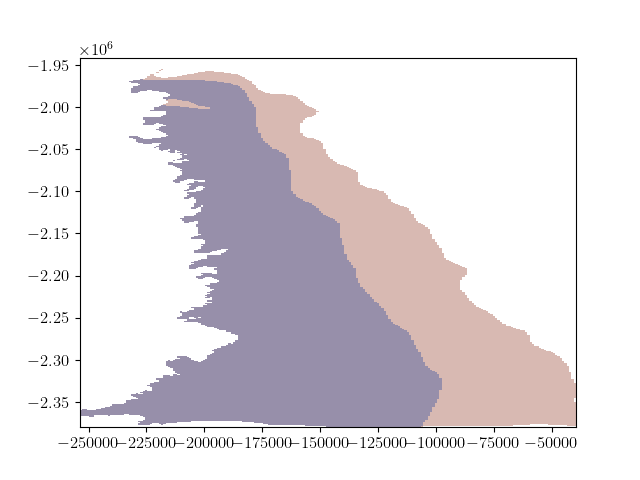

In [121]:
import pickle
with open('data/fdm/fdm_gre_cw_ru.pkl', 'rb') as file:
    ru_gre = pickle.load(file)
area19 = ru_gre['ru19'].copy()
area19[~np.isnan(area19)] = 1
area20 = ru_gre['ru20'].copy()
area20[~np.isnan(area20)] = 1
fig,ax = plt.subplots()
ax.pcolormesh(ru_gre['x'], ru_gre['y'], area19, cmap=cmc.roma, shading='nearest', vmin=1, vmax=2, alpha=0.3)
ax.pcolormesh(ru_gre['x'], ru_gre['y'], area20, cmap=cmc.roma, shading='nearest', vmin=0, vmax=1, alpha=0.3)

<Axes: >

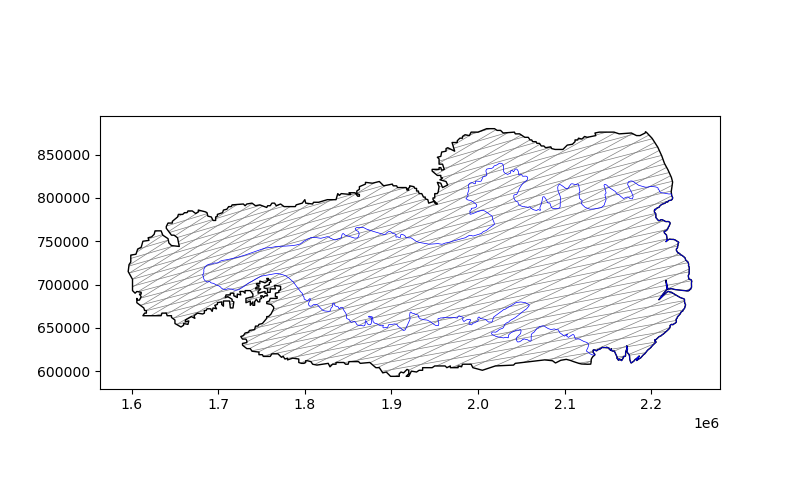

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
rgt_bc.plot(color='gray', ax=ax, lw=0.5)
bc.exterior.plot(color='k', ax=ax, lw=1)
amery.exterior.plot(color='b', ax=ax, lw=0.5)

loc=[0.69, 0.01]
width=0.3
height=0.25
bnds = [loc[0], loc[1], width, height]
axi = ax.inset_axes(bounds=bnds)
    
    if inset.lower().strip() == 'antarctica':
        coast = gpd.read_file('shapefiles/Coastline_Antarctica_v02.shp')
        shelf = gpd.read_file('shapefiles/IceShelf_Antarctica_v02.shp')
        ground = gpd.read_file('shapefiles/GroundingLine_Antarctica_v02.shp')
        tol = 30000
        ground.dissolve().simplify(tolerance=tol).plot(color=[0.95]*3, ax=axi, lw=0.5, alpha=1)
        shelf.dissolve().simplify(tolerance=tol).plot(color=[0.85]*3, ax=axi, lw=0.5, alpha=1)
        ground.boundary.simplify(tolerance=tol).plot(color='k', ax=axi, lw=0.1)
        coast.simplify(tolerance=tol).exterior.plot(color='k', ax=axi, lw=0.3)
        point = gpd.GeoSeries(Point(lon, lat), crs='EPSG:4326').to_crs(coast.crs)
        axi.scatter(point.loc[0].x, point.loc[0].y, s=4, color='r', zorder=1000)
        
    axi.axis('off')

In [25]:
gris_final = gpd.read_file('basins/shapefiles/GRE_basins_thresh2000.shp')

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,geometry
55,28,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1728000.000 631076.228, 1730..."
1684,843,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"LINESTRING (2218372.189 763452.236, 2216015.69..."
1945,973,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"LINESTRING (1726312.257 639531.614, 1730262.96..."
800,401,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"LINESTRING (2215374.887 773605.242, 2213547.82..."
1061,531,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1762266.373 668532.746, 1763..."
...,...,...,...,...,...,...,...,...,...,...,...,...
526,264,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1669048.891 785000.000, 1664..."
1671,836,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1597066.306 713080.650, 1598..."
787,394,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1596910.824 722286.596, 1600..."
2677,1339,NaN,NaN,NaN,NaN,clampToGround,-1,0,1,NaN,NaN,"MULTILINESTRING ((1599000.000 732979.833, 1601..."


In [16]:
import shapely

In [2]:
ais_final = gpd.read_file('basins/shapefiles/ANT_basins_thresh1000.shp')
gris_final = gpd.read_file('basins/shapefiles/GRE_basins_thresh2000.shp')

bc = ais_final.loc[ais_final.Subregions=='B-C']
cw = gris_final.loc[gris_final.SUBREGION1=='CW']

In [5]:
# function to add map inset
#####################################################################
def add_inset(fig, lat, lon, inset, loc=[0.69, 0.01], width=0.3, height=0.25):
    
    if not inset:
        return
    
    axs = fig.axes
    ax = axs[0]
    bnds = [loc[0], loc[1], width, height]
    axi = ax.inset_axes(bounds=bnds)
    
    if inset.lower().strip() == 'antarctica':
        coast = gpd.read_file('shapefiles/Coastline_Antarctica_v02.shp')
        shelf = gpd.read_file('shapefiles/IceShelf_Antarctica_v02.shp')
        ground = gpd.read_file('shapefiles/GroundingLine_Antarctica_v02.shp')
        tol = 30000
        ground.dissolve().simplify(tolerance=tol).plot(color=[0.95]*3, ax=axi, lw=0.5, alpha=1)
        shelf.dissolve().simplify(tolerance=tol).plot(color=[0.85]*3, ax=axi, lw=0.5, alpha=1)
        ground.boundary.simplify(tolerance=tol).plot(color='k', ax=axi, lw=0.1)
        coast.simplify(tolerance=tol).exterior.plot(color='k', ax=axi, lw=0.3)
        point = gpd.GeoSeries(Point(lon, lat), crs='EPSG:4326').to_crs(coast.crs)
        axi.scatter(point.loc[0].x, point.loc[0].y, s=4, color='r', zorder=1000)
        
    axi.axis('off')

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import datetime

In [ ]:
def kml2df(kml_filename):

    with open(kml_filename, 'r') as file:
        kml_string = file.read()
    
    rgt = int(kml_filename[kml_filename.find('RGT_')+4:kml_filename.find('RGT_')+8])
        
    kml_string_line = kml_string[kml_string.find('LineString_kml'):kml_string.find('</LineString>')]
    kml_coords_str = '[[' + kml_string_line[kml_string_line.find('<coordinates>')+len('<coordinates>'):kml_string_line.find('</coordinates>')-1] + ']]'
    kml_coords_str = kml_coords_str.replace(' ', '],[')
    kml_coords_array = np.array(eval(kml_coords_str))
    kml_lat = kml_coords_array[:,1]
    kml_lon = kml_coords_array[:,0] 
    kml_df = pd.DataFrame({'lat': kml_lat, 'lon': kml_lon, 'rgt': rgt})
    
    # find the first timestamp
    substr = kml_string[kml_string.find('<Point id='):kml_string.find('</Point>')+100]
    descr = substr[substr.find('<name>')+len('<name>'):substr.find('</name>')]
    dt_str = descr[descr.find('DOY-'):]
    dt_str = dt_str[dt_str.find(' ')+1:]
    day = int(dt_str[:dt_str.find('-')])
    month_abbr = dt_str[dt_str.find('-')+1:dt_str.rfind('-')]
    year = int(dt_str[dt_str.rfind('-')+1:dt_str.find(' ')])
    hrs = int(dt_str[dt_str.find(' ')+1:dt_str.find(':')])
    mins = int(dt_str[dt_str.find(':')+1:dt_str.rfind(':')])
    secs = int(dt_str[dt_str.rfind(':')+1:])
    datetime_str = '%4i-%3s-%02iT%02i:%02i:%02iZ' % (year, month_abbr, day, hrs, mins, secs)
    dt = datetime.datetime.strptime(datetime_str,'%Y-%b-%dT%H:%M:%SZ')
    timestamp_utc = datetime.datetime.timestamp(dt)
    kml_df['timestamp'] = timestamp_utc + np.arange(len(kml_df))
    kml_df['time_str'] = [datetime.datetime.strftime(datetime.datetime.fromtimestamp(t), '%a %Y-%b-%d %H:%M:%S') for t in kml_df.timestamp]
    
    return kml_df

In [3]:
import os
import requests
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

In [4]:
# for downloading all KML files (need to update url list manually)
def download_kmls(download_dir_kmls_zip, kml_url_list=None, download_zip=True):

    # Download the Zip files
    if not os.path.exists(download_dir_kmls_zip):
        os.makedirs(download_dir_kmls_zip)
        
    if download_zip: 
        for url in kml_url_list:
            kml_zip_fn = url[url.rfind('/')+1:]
            kml_zip_path = download_dir_kmls_zip + '/' + kml_zip_fn
            print('downloading', kml_zip_path)
            response = requests.get(url, stream=True, allow_redirects=True)
            total_size_in_bytes= int(response.headers.get('content-length', 0))
            block_size = 1024 #1 Kibibyte
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(kml_zip_path, 'wb') as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()
            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")

    # Unzip outputs
    for z in os.listdir(download_dir_kmls_zip): 
        if z.endswith('.zip'): 
            zip_name = download_dir_kmls_zip + "/" + z 
            print('--> extracting', zip_name)
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(download_dir_kmls_zip) 
            zip_ref.close() 
            os.remove(zip_name)

    print('Cleaning up outputs folder...', end=' ')
    for root, dirs, files in os.walk(download_dir_kmls_zip, topdown=False):
        for file in files:
            try:
                shutil.move(os.path.join(root, file), download_dir_kmls_zip)
            except OSError:
                pass
        for name in dirs:
            shutil.rmtree(root+'/'+name, ignore_errors=True)
    print(' --> DONE!')

    kml_filelist = [download_dir_kmls_zip+'/'+f for f in os.listdir(download_dir_kmls_zip) \
                    if os.path.isfile(os.path.join(download_dir_kmls_zip, f))]

In [5]:
download_path = 'data/kmls/raw'

url_list = ['https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/antarcticaallorbits.zip',
            'https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/arcticallorbits.zip'
            ]

download_kmls(download_path, kml_url_list=url_list, download_zip=True)

downloading data/kmls/raw/antarcticaallorbits.zip


100%|██████████| 162M/162M [00:03<00:00, 43.8MiB/s] 


downloading data/kmls/raw/arcticallorbits.zip


100%|██████████| 133M/133M [00:03<00:00, 40.9MiB/s] 


--> extracting data/kmls/raw/arcticallorbits.zip
--> extracting data/kmls/raw/antarcticaallorbits.zip
Cleaning up outputs folder...  --> DONE!
